# OBJECTIVE :- Apply GBDT(Gradient Boosting Decision Tree) and RF(Random Forest) on Amazon Fine Food Reviews Dataset¶

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


RANDOMLY SAMPLING 100K POINTS OUT OF WHOLE DATASET

In [10]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 100K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

(100000, 11)


# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 1000) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (70000, 465)
the number of unique words : 465


# (1.a) Random Forest(RF) with GridSearchCV

In [12]:
# Importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

base_learners = [40,60,80,100,120]

param_grid = {'n_estimators': base_learners}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_rf_learners = optimal_learners
bow_rf_train_acc = model.score(X_test_vec, Y_test)*100
bow_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8780666666666667
The optimal number of base learners is :  80


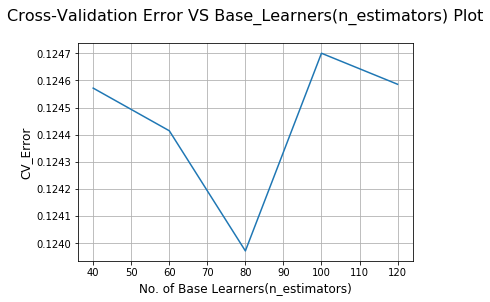

In [14]:
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(base_learners, cv_errors)
plt.xlabel('No. of Base Learners(n_estimators)',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Base_Learners(n_estimators) Plot\n',size=16)
plt.grid()
plt.show()

In [15]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 80 is 87.946667%

The Test Precision of the RandomForestClassifier for base_learners = 80 is 0.882679

The Test Recall of the RandomForestClassifier for base_learners = 80 is 0.988331

The Test F1-Score of the RandomForestClassifier for base_learners = 80 is 0.932522


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

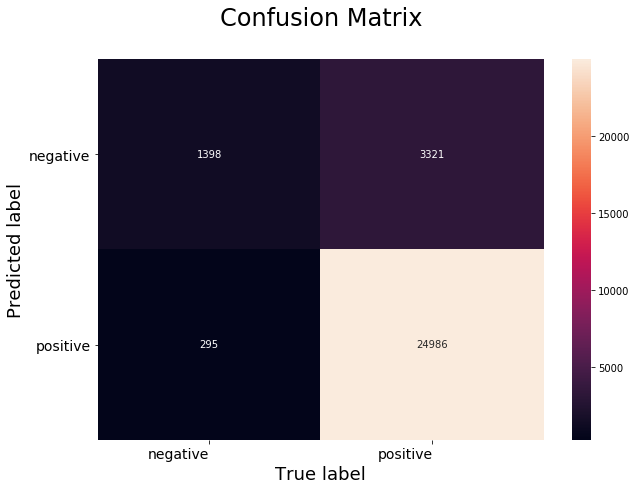

In [16]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (1.b) Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [17]:
# Importing library
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [200,300,400,500,600]
Depths = [1,3,5,7,9,11]
Learning_rate = [0.05,0.1,0.2,0.3]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'accuracy', cv=5 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# Optimal value of learning rate
optimal_rate = model.best_estimator_.learning_rate
print("\nThe optimal value of learning rate is : ",optimal_rate)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=11,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8872666666666666
The optimal number of base learners is :  600

The optimal value of depth is :  11

The optimal value of learning rate is :  0.05


In [49]:
arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(rate,depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_rate[i],arr_depth[i],arr_estimator[i])))  

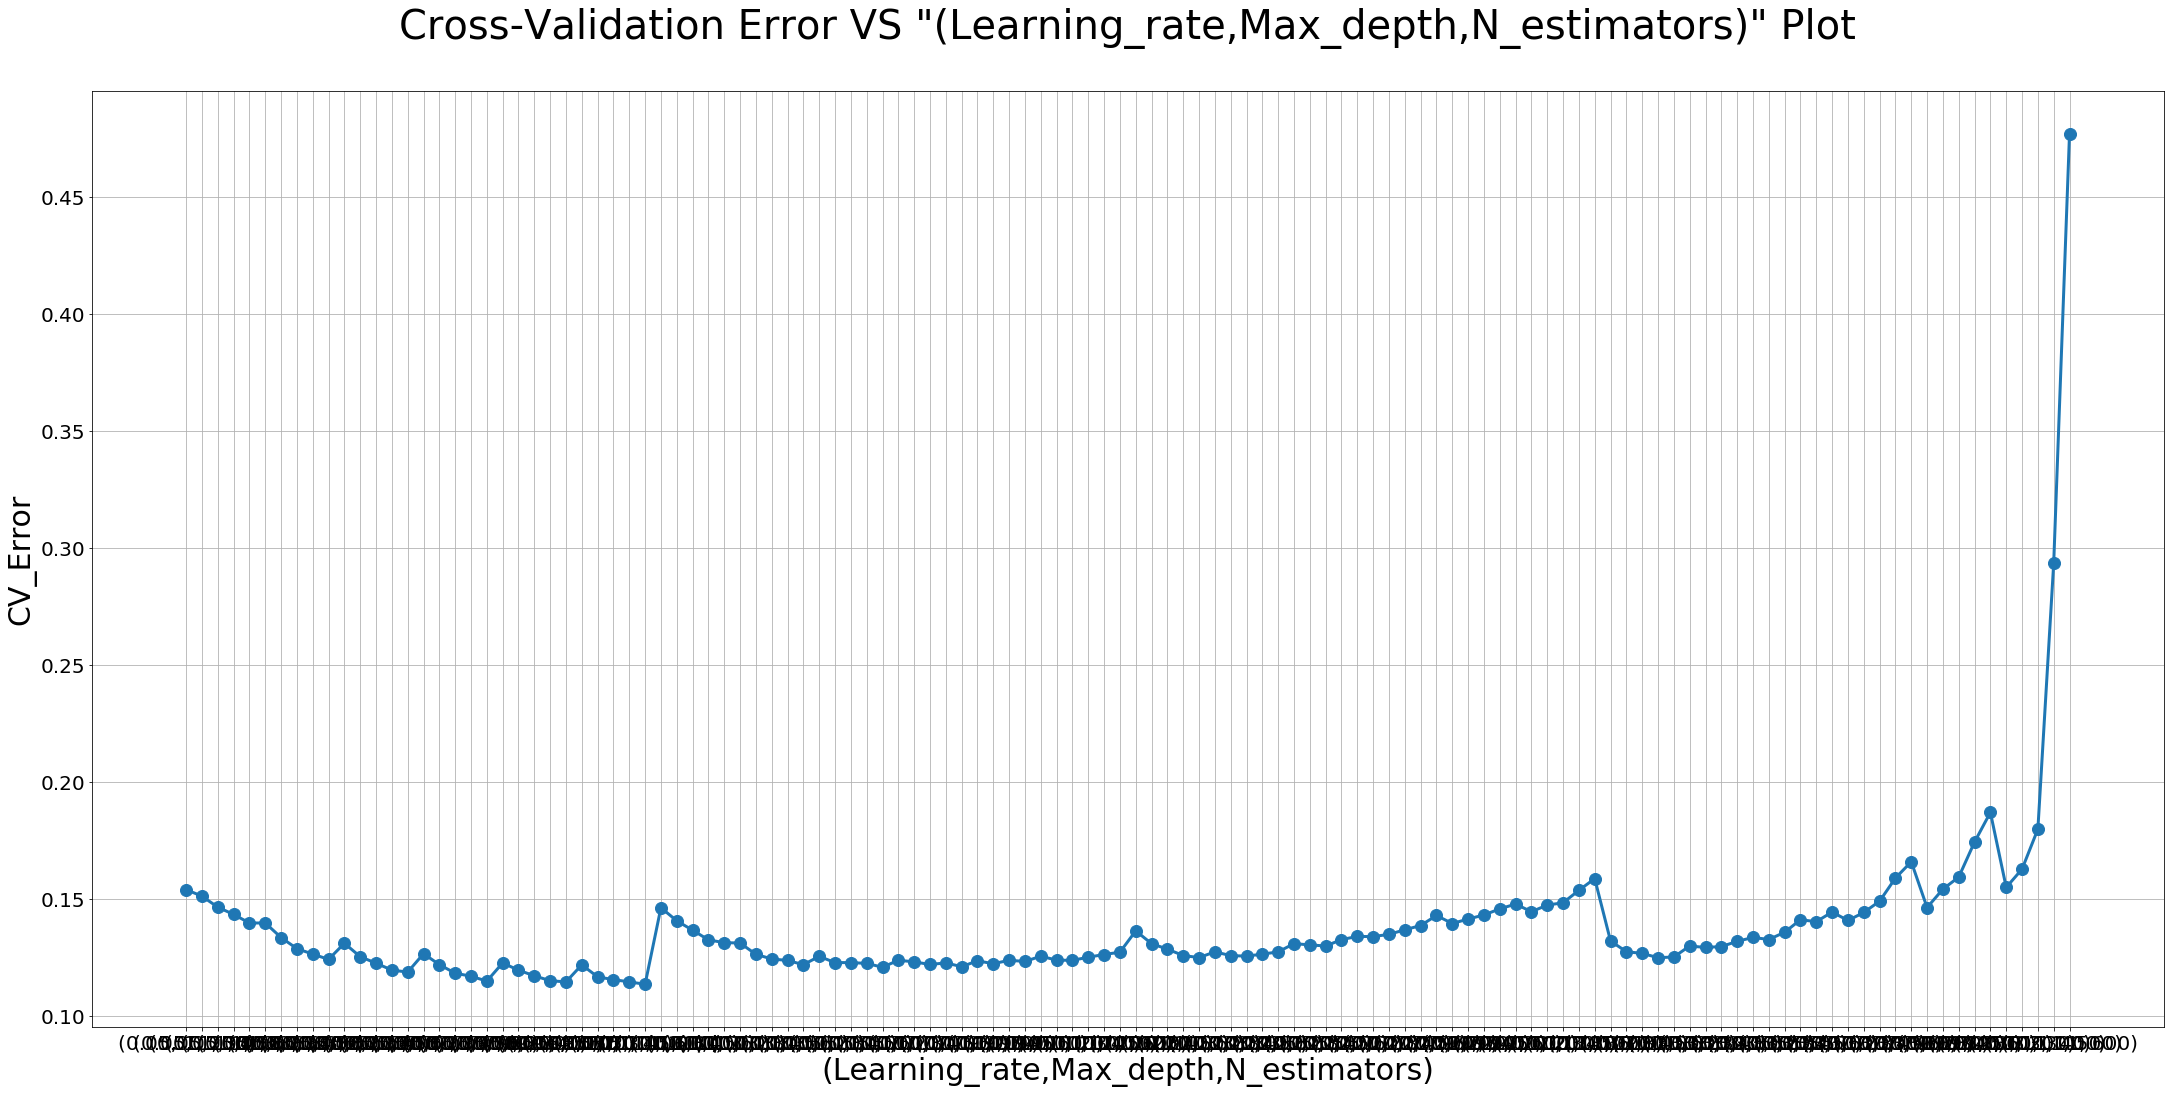

In [50]:
# plotting Cross-Validation Error vs tuples of (Learning_rate,Max_depth,N_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(Learning_rate,Max_depth,N_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(Learning_rate,Max_depth,N_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

In [51]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, learning_rate=optimal_rate, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_gbdt_learners = optimal_learners
bow_gbdt_depth = optimal_depth
bow_gbdt_rate = optimal_rate
bow_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
bow_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))



Test Accuracy of the GradientBoostingClassifier for base_learners = 600 , depth = 11 and learning_rate = 0.050 is 88.790000%

Test Precision of the GradientBoostingClassifier for base_learners = 600 , depth = 11 and learning_rate = 0.050 is 0.904929

Test Recall of the GradientBoostingClassifier for base_learners = 600 , depth = 11 and learning_rate = 0.050 is 0.968751

Test F1-Score of the GradientBoostingClassifier for base_learners = 600 , depth = 11 and learning_rate = 0.050 is 0.935753


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

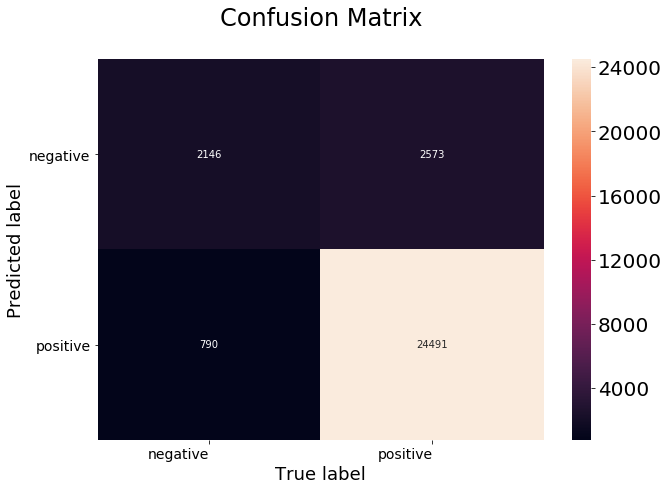

In [52]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2) TFIDF

In [53]:
tf_idf_vect = TfidfVectorizer(min_df=1000)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (70000, 465)
the number of unique words : 465


# (2.a) Random Forest(RF) with GridSearchCV

In [54]:
base_learners = [40,60,80,100,120]

param_grid = {'n_estimators': base_learners}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_rf_learners = optimal_learners
tfidf_rf_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8762333333333333
The optimal number of base learners is :  80


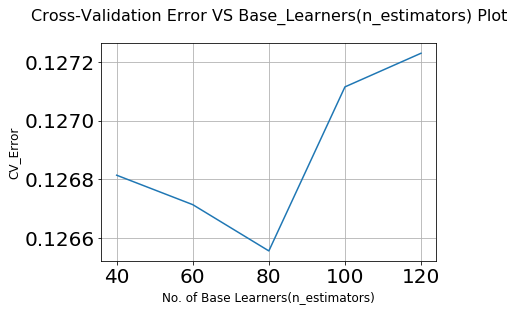

In [55]:
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(base_learners, cv_errors)
plt.xlabel('No. of Base Learners(n_estimators)',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Base_Learners(n_estimators) Plot\n',size=16)
plt.grid()
plt.show()

In [56]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 80 is 87.650000%

The Test Precision of the RandomForestClassifier for base_learners = 80 is 0.878633

The Test Recall of the RandomForestClassifier for base_learners = 80 is 0.990230

The Test F1-Score of the RandomForestClassifier for base_learners = 80 is 0.931099


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

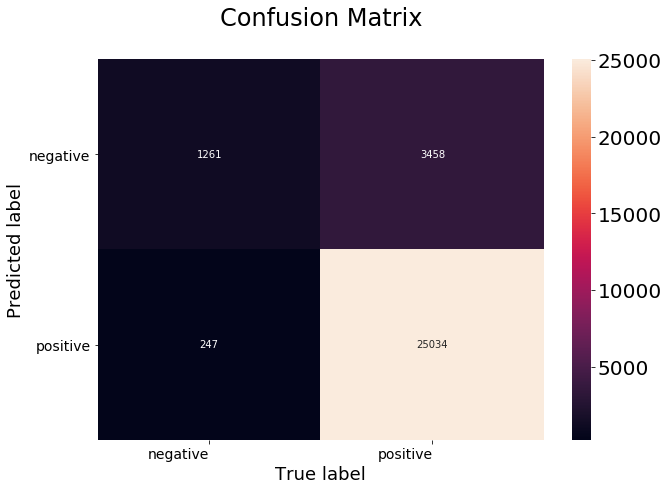

In [57]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2.b) Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [58]:
base_learners = [200,300,400,500,600]
Depths = [1,3,5,7,9,11]
Learning_rate = [0.05,0.1,0.2,0.3]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# Optimal value of learning rate
optimal_rate = model.best_estimator_.learning_rate
print("\nThe optimal value of learning rate is : ",optimal_rate)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8841666666666667
The optimal number of base learners is :  600

The optimal value of depth is :  9

The optimal value of learning rate is :  0.05


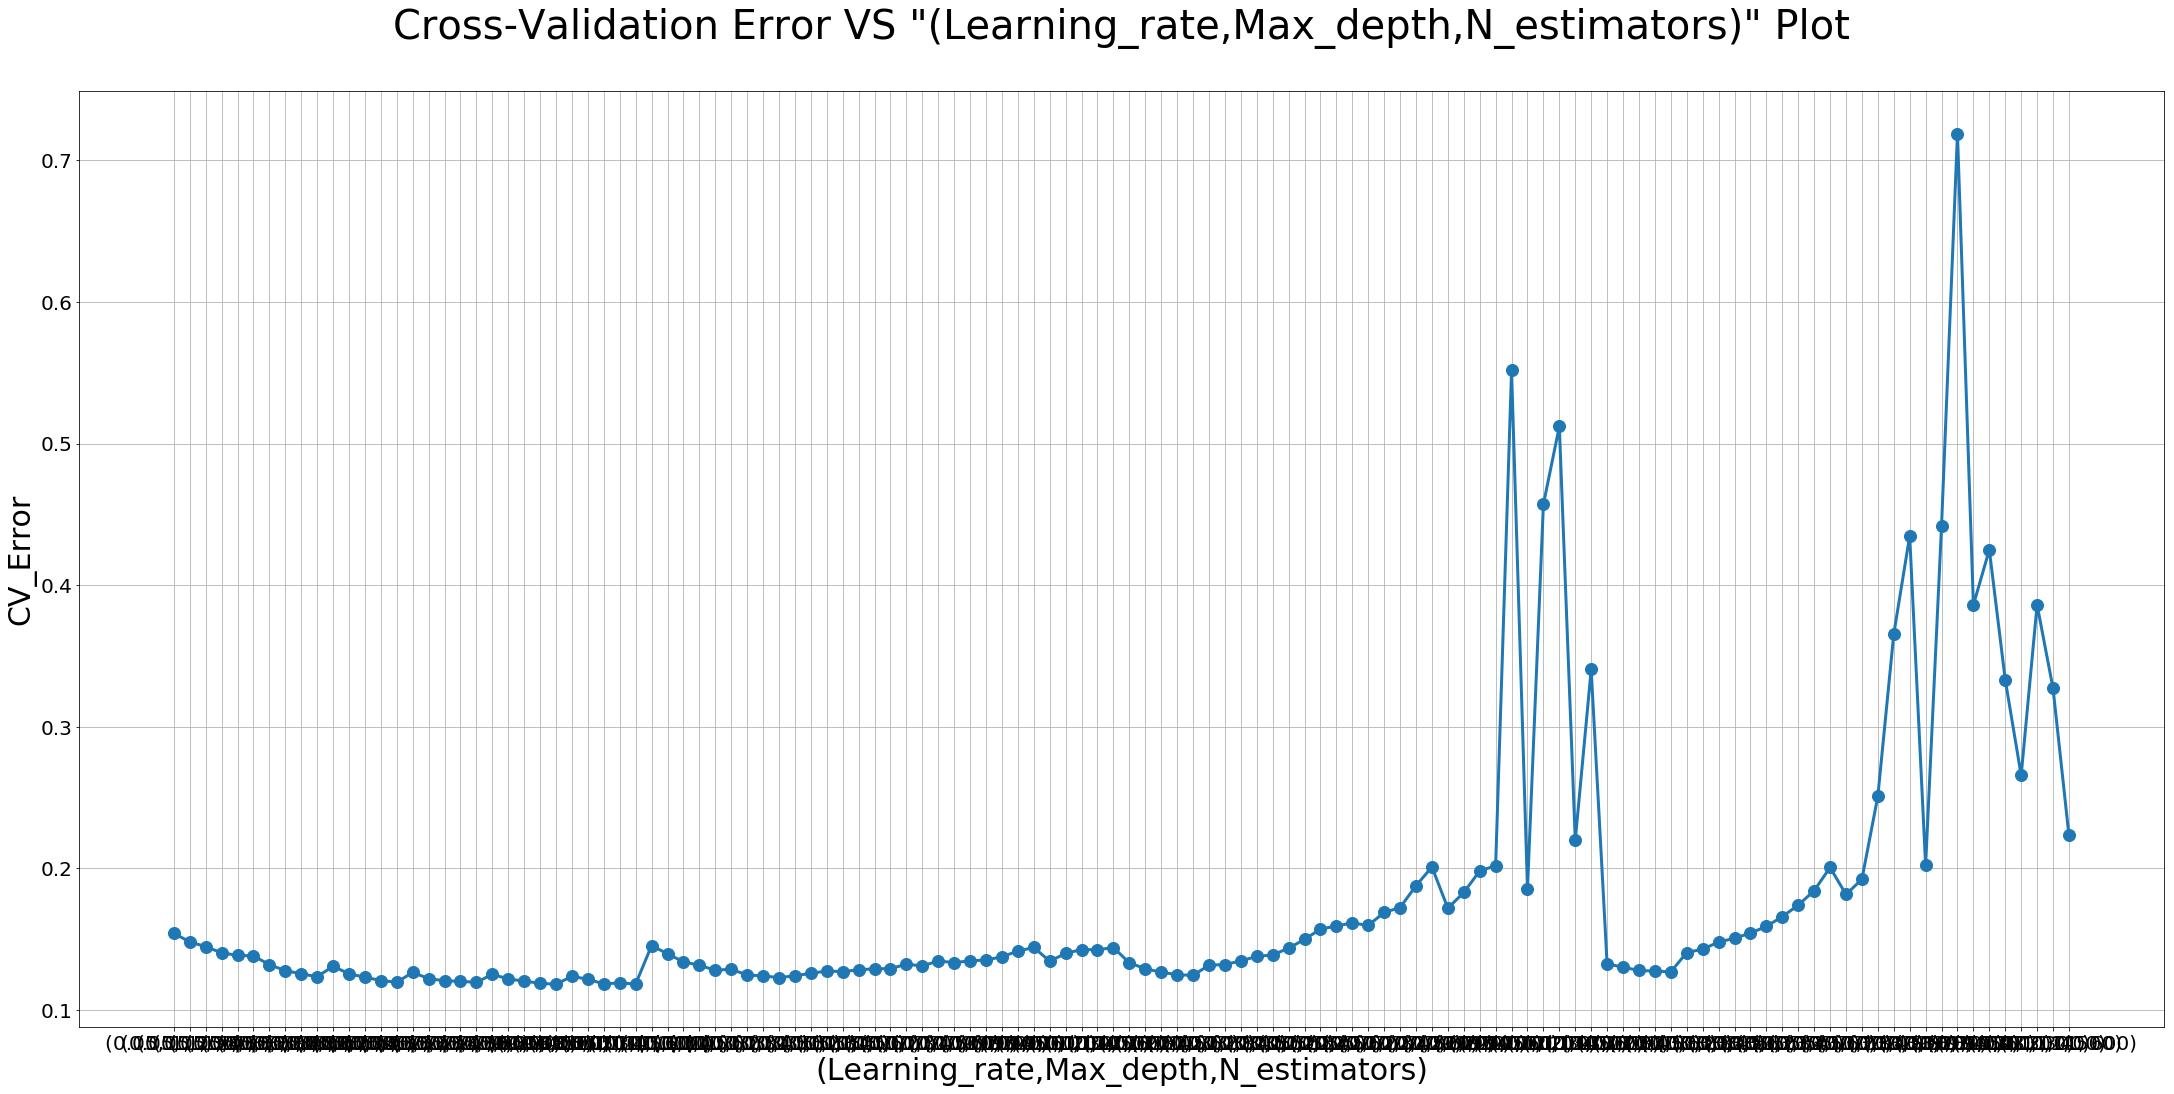

In [59]:
arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(rate,depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_rate[i],arr_depth[i],arr_estimator[i]))) 
    
# plotting Cross-Validation Error vs tuples of (Learning_rate,Max_depth,N_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(Learning_rate,Max_depth,N_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(Learning_rate,Max_depth,N_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()    

In [60]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, learning_rate=optimal_rate, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_gbdt_learners = optimal_learners
tfidf_gbdt_depth = optimal_depth
tfidf_gbdt_rate = optimal_rate
tfidf_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))



Test Accuracy of the GradientBoostingClassifier for base_learners = 600 , depth = 9 and learning_rate = 0.050 is 88.356667%

Test Precision of the GradientBoostingClassifier for base_learners = 600 , depth = 9 and learning_rate = 0.050 is 0.899545

Test Recall of the GradientBoostingClassifier for base_learners = 600 , depth = 9 and learning_rate = 0.050 is 0.970175

Test F1-Score of the GradientBoostingClassifier for base_learners = 600 , depth = 9 and learning_rate = 0.050 is 0.933526


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

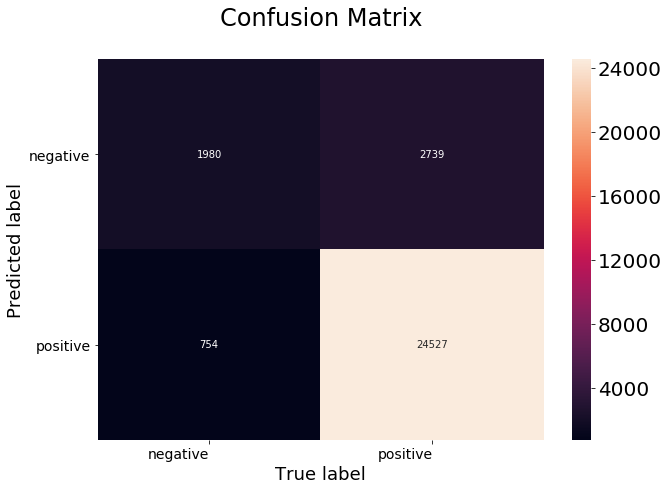

In [61]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Word2Vec

In [62]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  10770


# (3). Avg Word2Vec

In [63]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
X_train_vec = train_vectors
X_test_vec = test_vectors     

# (3.a) Random Forest(RF) with GridSearchCV

In [64]:
base_learners = [40,60,80,100,120]

param_grid = {'n_estimators': base_learners}
RFC = RandomForestClassifier(max_features=0.2)
model = GridSearchCV(RFC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features=0.2, n_jobs=-1)
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_rf_learners = optimal_learners
avg_w2v_rf_train_acc = model.score(X_test_vec, Y_test)*100
avg_w2v_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8833666666666666
The optimal number of base learners is :  120


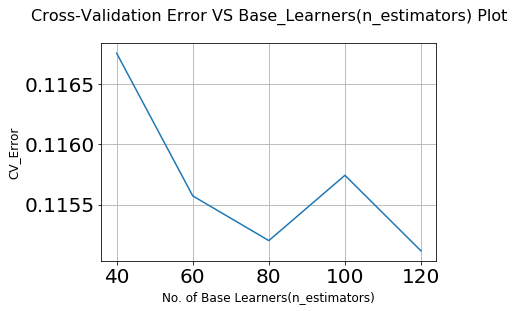

In [65]:
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(base_learners, cv_errors)
plt.xlabel('No. of Base Learners(n_estimators)',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Base_Learners(n_estimators) Plot\n',size=16)
plt.grid()
plt.show()

In [66]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 120 is 88.373333%

The Test Precision of the RandomForestClassifier for base_learners = 120 is 0.891243

The Test Recall of the RandomForestClassifier for base_learners = 120 is 0.981844

The Test F1-Score of the RandomForestClassifier for base_learners = 120 is 0.934352


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

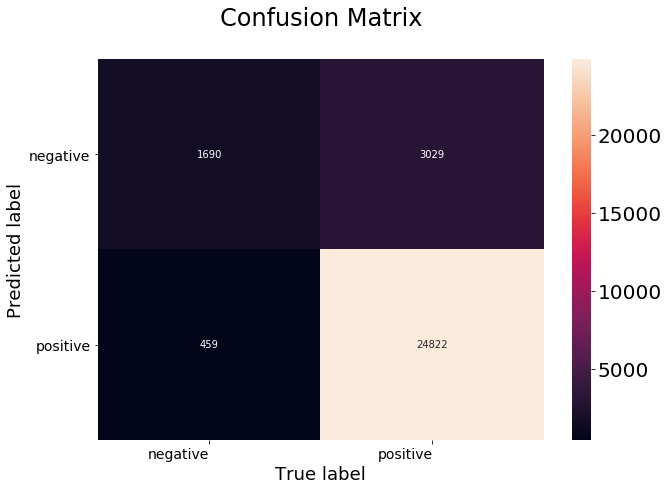

In [67]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (3.b) Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [68]:
base_learners = [200,300,400,500,600]
Depths = [1,3,5,7,9,11]
Learning_rate = [0.05,0.1,0.2,0.3]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
GBC = GradientBoostingClassifier(max_features=0.2,subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# Optimal value of learning rate
optimal_rate = model.best_estimator_.learning_rate
print("\nThe optimal value of learning rate is : ",optimal_rate)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8929
The optimal number of base learners is :  600

The optimal value of depth is :  3

The optimal value of learning rate is :  0.05


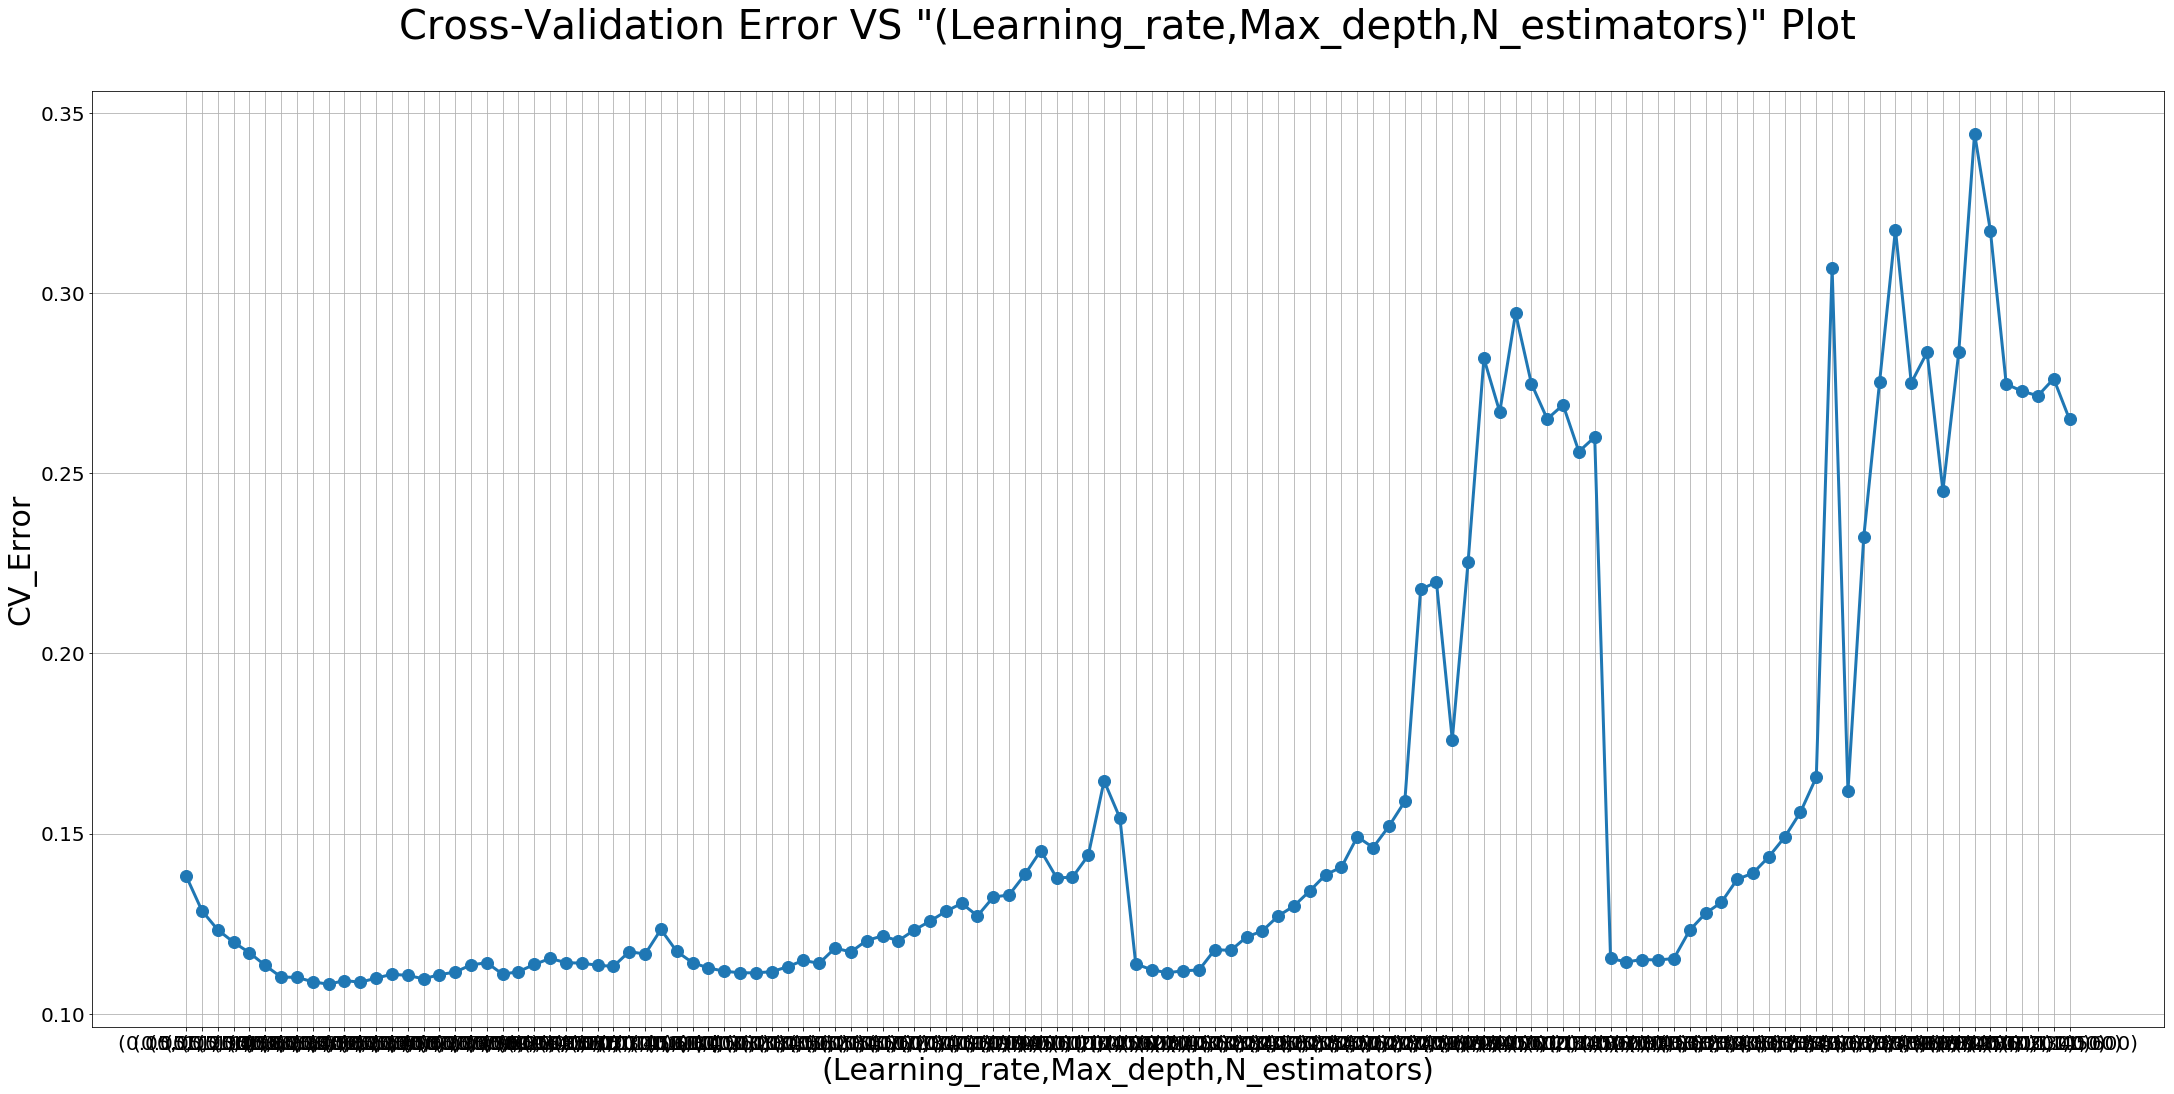

In [69]:
arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(rate,depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_rate[i],arr_depth[i],arr_estimator[i]))) 
    
# plotting Cross-Validation Error vs tuples of (Learning_rate,Max_depth,N_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(Learning_rate,Max_depth,N_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(Learning_rate,Max_depth,N_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

In [70]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, learning_rate=optimal_rate, max_features=0.2, subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_gbdt_learners = optimal_learners
avg_w2v_gbdt_depth = optimal_depth
avg_w2v_gbdt_rate = optimal_rate
avg_w2v_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
avg_w2v_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))



Test Accuracy of the GradientBoostingClassifier for base_learners = 600 , depth = 3 and learning_rate = 0.050 is 89.133333%

Test Precision of the GradientBoostingClassifier for base_learners = 600 , depth = 3 and learning_rate = 0.050 is 0.908356

Test Recall of the GradientBoostingClassifier for base_learners = 600 , depth = 3 and learning_rate = 0.050 is 0.968791

Test F1-Score of the GradientBoostingClassifier for base_learners = 600 , depth = 3 and learning_rate = 0.050 is 0.937600


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

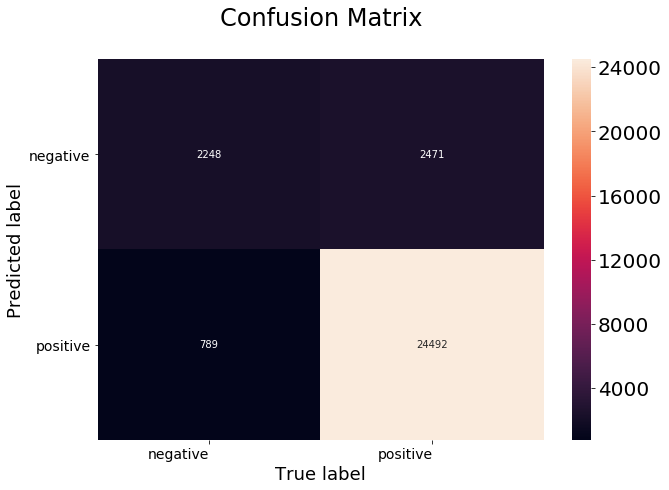

In [71]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4). TFIDF-Word2Vec

In [72]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [73]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
X_train_vec = tfidf_train_vectors
X_test_vec = tfidf_test_vectors 

# (4.a) Random Forest(RF) with GridSearchCV

In [74]:
base_learners = [40,60,80,100,120]

param_grid = {'n_estimators': base_learners}
RFC = RandomForestClassifier(max_features=0.2)
model = GridSearchCV(RFC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features=0.2, n_jobs=-1)
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_rf_learners = optimal_learners
tfidf_w2v_rf_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_w2v_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.7685666666666666
The optimal number of base learners is :  80


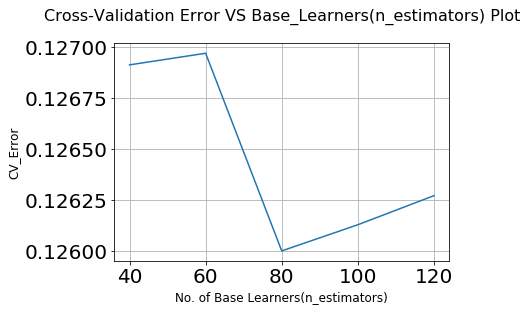

In [75]:
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(base_learners, cv_errors)
plt.xlabel('No. of Base Learners(n_estimators)',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Base_Learners(n_estimators) Plot\n',size=16)
plt.grid()
plt.show()

In [76]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 80 is 77.393333%

The Test Precision of the RandomForestClassifier for base_learners = 80 is 0.851839

The Test Recall of the RandomForestClassifier for base_learners = 80 is 0.885804

The Test F1-Score of the RandomForestClassifier for base_learners = 80 is 0.868489


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

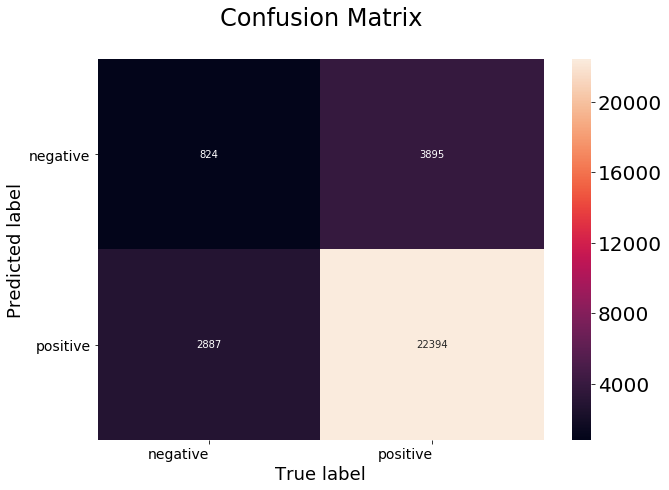

In [77]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4.b) Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [78]:
base_learners = [200,300,400,500,600]
Depths = [1,3,5,7,9,11]
Learning_rate = [0.05,0.1,0.2,0.3]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
GBC = GradientBoostingClassifier(max_features=0.2,subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# Optimal value of learning rate
optimal_rate = model.best_estimator_.learning_rate
print("\nThe optimal value of learning rate is : ",optimal_rate)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.6594333333333333
The optimal number of base learners is :  500

The optimal value of depth is :  5

The optimal value of learning rate is :  0.05


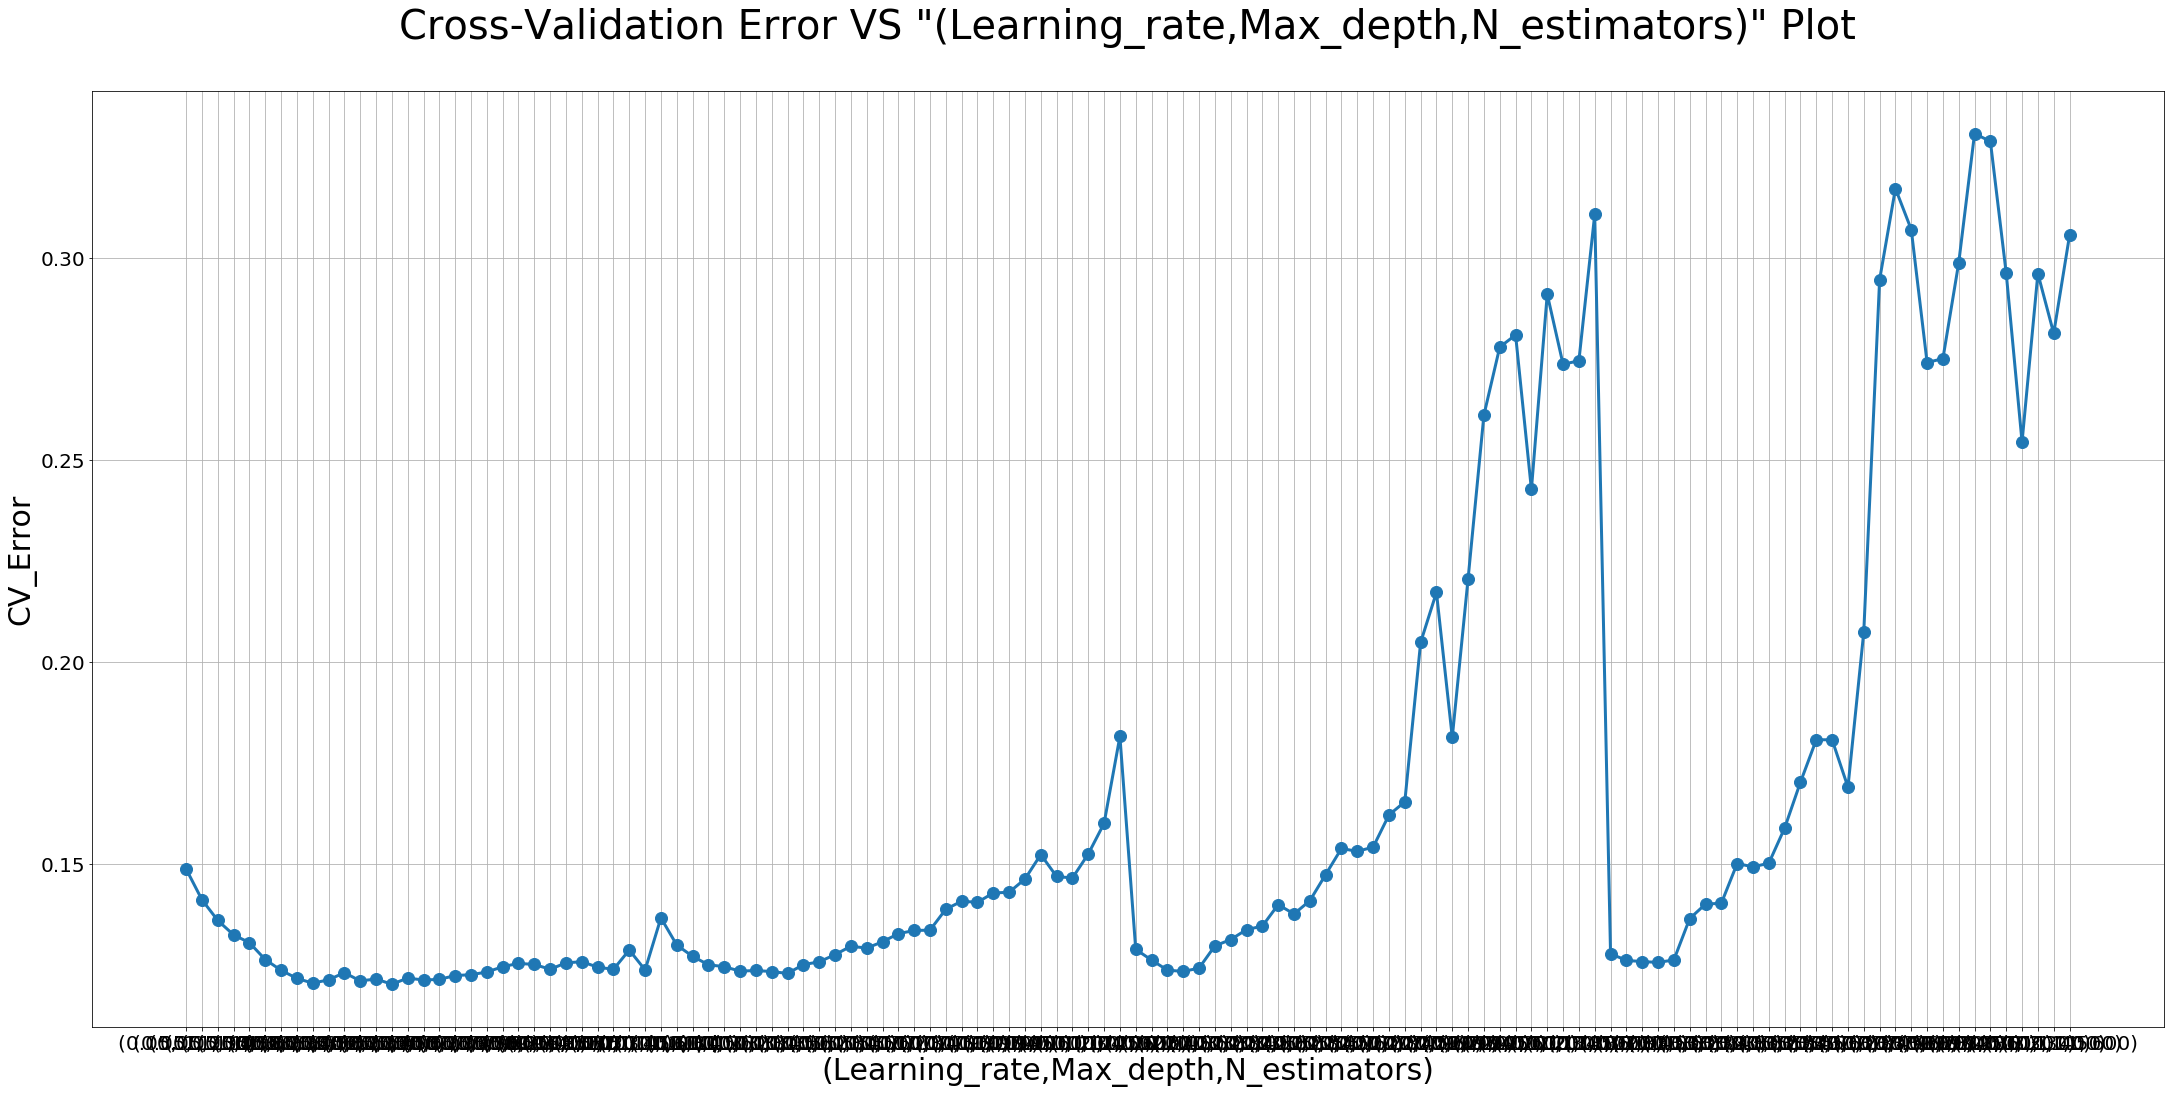

In [79]:
arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(rate,depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_rate[i],arr_depth[i],arr_estimator[i]))) 
    
# plotting Cross-Validation Error vs tuples of (Learning_rate,Max_depth,N_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(Learning_rate,Max_depth,N_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(Learning_rate,Max_depth,N_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

In [80]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, learning_rate=optimal_rate, max_features=0.2, subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_gbdt_learners = optimal_learners
tfidf_w2v_gbdt_depth = optimal_depth
tfidf_w2v_gbdt_rate = optimal_rate
tfidf_w2v_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_w2v_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))



Test Accuracy of the GradientBoostingClassifier for base_learners = 500 , depth = 5 and learning_rate = 0.050 is 67.733333%

Test Precision of the GradientBoostingClassifier for base_learners = 500 , depth = 5 and learning_rate = 0.050 is 0.858957

Test Recall of the GradientBoostingClassifier for base_learners = 500 , depth = 5 and learning_rate = 0.050 is 0.738341

Test F1-Score of the GradientBoostingClassifier for base_learners = 500 , depth = 5 and learning_rate = 0.050 is 0.794095


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

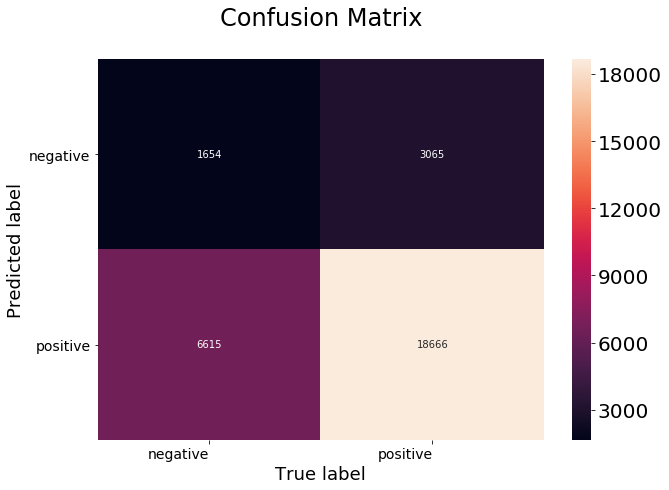

In [81]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION :-

# (a). Procedure followed :

STEP 1 :- Text Preprocessing

STEP 2:- Time-based splitting of whole dataset into train_data and test_data

STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors

STEP 4:- Using Random Forest as an estimator in GridSearchCV in order to find optimal value of base_learners . 

STEP 5:- Once , we get optimal value of base_learners then train Random Forest again with this optimal value of base_learners and make predictions on test_data

STEP 6:- Draw Cross_Validation Error VS Base_Learners(n_estimators) plot

STEP 7 :- Evaluate : Accuracy , F1-Score , Precision , Recall

STEP 8:- Draw Seaborn Heatmap for Confusion Matrix .

STEP 9:- Using GBDT as an estimator in GridSearchCV in order to find optimal value of base_learners , depth and learning_rate .

STEP 10:- Once , we get optimal values (of base_learners ,depth and learning_rate) , then train GBDT again with thess optimal values (of base_learners , depth , learning_rate) and after that make predictions on test_data

STEP 11:- Draw Cross-Validation Error vs tuples of (Learning_rate,Max_depth,N_estimators) graph

STEP 12:- Evaluate : Accuracy , F1-Score , Precision , Recall

STEP 13:- Draw Seaborn Heatmap for Confusion Matrix .

Repeat from STEP 3 to STEP 13 for each of these four vectorizers : Bag Of Words(BoW), TFIDF, Avg Word2Vec and TFIDF Word2Vec

# (b). Table (Model Performances with their hyperparameters :

In [82]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Table for Random Forest
names_rf = ['Random Forest for BoW','Random Forest for TFIDF','Random Forest for Avg_Word2Vec',\
            'Random Forest for tfidf_Word2Vec']

learners_rf = [bow_rf_learners,tfidf_rf_learners,avg_w2v_rf_learners,tfidf_w2v_rf_learners]

train_acc_rf = [bow_rf_train_acc,tfidf_rf_train_acc,avg_w2v_rf_train_acc,tfidf_w2v_rf_train_acc]

test_acc_rf = [bow_rf_test_acc,tfidf_rf_test_acc,avg_w2v_rf_test_acc,tfidf_w2v_rf_test_acc]

numbering_rf = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering_rf)
ptable.add_column("MODEL",names_rf)
ptable.add_column("Base Learners ",learners_rf)
ptable.add_column("Training Accuracy",train_acc_rf)
ptable.add_column("Test Accuracy",test_acc_rf)

print('\t\t\t\t\tTABLE FOR RANDOM FOREST')
# Printing the Table
print(ptable)
print("\n\n")




# Table for Gradient Boosting Decision Tree (GBDT)
names = ['GBDT for BoW','GBDT for TFIDF','GBDT for Avg_Word2Vec','GBDT for tfidf_Word2Vec']

base_learners = [bow_gbdt_learners,tfidf_gbdt_learners,avg_w2v_gbdt_learners,tfidf_w2v_gbdt_learners]

optimal_depth = [bow_gbdt_depth,tfidf_gbdt_depth,avg_w2v_gbdt_depth,tfidf_w2v_gbdt_depth]

learn_rate = [bow_gbdt_rate,tfidf_gbdt_rate,avg_w2v_gbdt_rate,tfidf_w2v_gbdt_rate]

train_acc = [bow_gbdt_train_acc,tfidf_gbdt_train_acc,avg_w2v_gbdt_train_acc,tfidf_w2v_gbdt_train_acc]

test_acc = [bow_gbdt_test_acc,tfidf_gbdt_test_acc,avg_w2v_gbdt_test_acc,tfidf_w2v_gbdt_test_acc]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Base Learners ",base_learners)
table.add_column("Optimal_Depth",optimal_depth)
table.add_column("Learning_Rate",learn_rate)
table.add_column("Training Accuracy",train_acc)
table.add_column("Test Accuracy",test_acc)

print('\t\t\t\tTABLE FOR GRADIENT BOOSTING DECISION TREE (GBDT)')
# Printing the Table
print(table)

					TABLE FOR RANDOM FOREST
+-------+----------------------------------+----------------+-------------------+-------------------+
| S.NO. |              MODEL               | Base Learners  | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------+----------------+-------------------+-------------------+
|   1   |      Random Forest for BoW       |       80       | 87.80666666666667 | 87.94666666666666 |
|   2   |     Random Forest for TFIDF      |       80       | 87.62333333333333 | 87.64999999999999 |
|   3   |  Random Forest for Avg_Word2Vec  |      120       | 88.33666666666666 | 88.37333333333333 |
|   4   | Random Forest for tfidf_Word2Vec |       80       | 76.85666666666665 | 77.39333333333333 |
+-------+----------------------------------+----------------+-------------------+-------------------+



				TABLE FOR GRADIENT BOOSTING DECISION TREE (GBDT)
+-------+-------------------------+----------------+---------------+---------------+---------------